# Working with Pandas and XArray

This notebook demonstrates how Pandas and XArray can be used to work with the [QCoDeS DataSet](DataSet-class-walkthrough.ipynb). It is not meant as a general introduction to Pandas and XArray. We refer to the official documentation for [Pandas](https://pandas.pydata.org/) and [XArray](http://xarray.pydata.org/en/stable/) for this. This notebook requires that both Pandas and XArray are installed.

## Setup

First we borrow an example from the measurement notebook to have some data to work with. We split the measurement in two so we can try merging it with Pandas.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import qcodes as qc
from qcodes import load_or_create_experiment, initialise_database, Measurement
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement

qc.logger.start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/210308-5332-qcodes.log
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/210308-5332-qcodes.log


In [2]:
# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)
station = qc.Station(dmm, dac)

In [3]:
initialise_database()
exp = load_or_create_experiment(experiment_name='working_with_pandas',
                          sample_name="no sample")

In [4]:
meas = Measurement(exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(dmm.v2, setpoints=(dac.ch1, dac.ch2))  # register the dependent one

We then perform a very basic experiment. To be able to demonstrate merging of datasets in Pandas we will perform the measurement in two parts.

In [5]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(-1, 0, 200, endpoint=False):
        for v2 in np.linspace(-1, 1, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val))
            
dataset1 = datasaver.dataset

Starting experimental run with id: 49. 


In [6]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(0, 1, 201):
        for v2 in np.linspace(-1, 1, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v2, val))

dataset2 = datasaver.dataset

Starting experimental run with id: 50. 


Two methods exists for extracting data to pandas dataframes. `to_pandas_dataframe` exports all the data from the dataset into a single dataframe. 
`to_pandas_dataframe_dict` returns the data as a dict from measured (dependent) parameters to DataFrames. 

Please note that the `to_pandas_dataframe` is only intended to be used when all dependent parameters have the same setpoint. If this is not the case for the DataSet then `to_pandas_dataframe_dict` should be used.

In [7]:
df1 = dataset1.to_pandas_dataframe()
df2 = dataset2.to_pandas_dataframe()

## Working with Pandas

Lets first inspect the Pandas DataFrame. Note how both dependent variables are used for the index. Pandas refers to this as a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html). For visual clarity, we just look at the first N points of the dataset.

In [8]:
N = 10

In [9]:
df1[:N]

dmm_v2
dac_ch1 dac_ch2          
-1.0    -1.00   -0.000045
        -0.99    0.000159
        -0.98    0.000386
        -0.97    0.000009
        -0.96    0.000039
        -0.95    0.000394
        -0.94   -0.000134
        -0.93   -0.000213
        -0.92    0.000261
        -0.91    0.000229

We can also reset the index to return a simpler view where all data points are simply indexed by a running counter. As we shall see below this can be needed in some situations. Note that calling `reset_index` leaves the original dataframe untouched.

In [10]:
df1.reset_index()[0:N]

,dac_ch1,dac_ch2,dmm_v2
0,-1.0,-1.00,-0.000045
1,-1.0,-0.99,0.000159
2,-1.0,-0.98,0.000386
3,-1.0,-0.97,0.000009
4,-1.0,-0.96,0.000039
5,-1.0,-0.95,0.000394
6,-1.0,-0.94,-0.000134
7,-1.0,-0.93,-0.000213
8,-1.0,-0.92,0.000261
9,-1.0,-0.91,0.000229


Pandas has built-in support for various forms of plotting. This does not, however, support MultiIndex at the moment so we use `reset_index` to make the data available for plotting.

<AxesSubplot:xlabel='dac_ch1', ylabel='dac_ch2'>

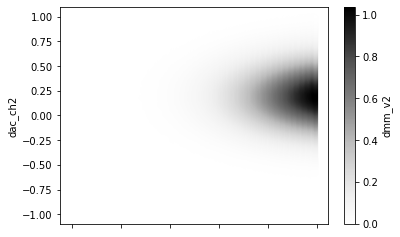

In [11]:
df1.reset_index().plot.scatter('dac_ch1', 'dac_ch2', c='dmm_v2')

Similarly, for the other dataframe:

<AxesSubplot:xlabel='dac_ch1', ylabel='dac_ch2'>

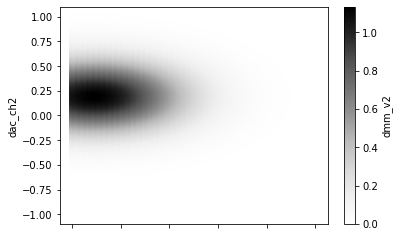

In [12]:
df2.reset_index().plot.scatter('dac_ch1', 'dac_ch2', c='dmm_v2')

Merging two dataframes with the same labels is fairly simple.

In [13]:
df = pd.concat([df1, df2], sort=True)

<AxesSubplot:xlabel='dac_ch1', ylabel='dac_ch2'>

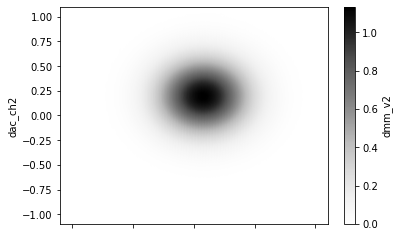

In [14]:
df.reset_index().plot.scatter('dac_ch1', 'dac_ch2', c='dmm_v2')

It is also possible to select a subset of data from the datframe based on the x and y values.

In [15]:
df.loc[(slice(-1, -0.95), slice(-1, -0.97)), :]

dmm_v2
dac_ch1 dac_ch2              
-1.000  -1.00   -4.545702e-05
        -0.99    1.592304e-04
        -0.98    3.863458e-04
        -0.97    9.280689e-06
-0.995  -1.00    3.229008e-05
        -0.99    1.136822e-03
        -0.98    4.187387e-04
        -0.97    1.313022e-05
-0.990  -1.00    4.763850e-04
        -0.99   -2.847793e-05
        -0.98    2.522367e-04
        -0.97   -1.998122e-04
-0.985  -1.00   -2.109175e-04
        -0.99   -3.427885e-04
        -0.98    1.753560e-04
        -0.97    8.166068e-05
-0.980  -1.00   -1.385113e-03
        -0.99   -5.664755e-04
        -0.98    3.711149e-04
        -0.97   -5.255515e-04
-0.975  -1.00    3.708092e-04
        -0.99   -8.744630e-04
        -0.98   -1.974403e-04
        -0.97   -3.405278e-04
-0.970  -1.00    3.182784e-05
        -0.99   -7.167590e-07
        -0.98   -1.681628e-05
        -0.97    5.324056e-04
-0.965  -1.00    2.305924e-04
        -0.99   -2.401110e-04
        -0.98   -9.875973e-04
        -0.97   -1.949306e-04
-0.960  -1.00   -7.453983e-04
        -0.99   -2.584045e-05
        -0.98    6.551673e-04
        -0.97   -5.601230e-04
-0.955  -1.00    1.823474e-04
        -0.99   -1.239956e-03
        -0.98   -1.021778e-04
        -0.97    6.101432e-04
-0.950  -1.00    9.644379e-04
        -0.99   -1.547160e-05
        -0.98   -5.423497e-04
        -0.97   -2.468558e-04

## Working with XArray

In many cases when working with data on rectangular grids it may be more convenient to export the data to a [XArray](http://xarray.pydata.org) Dataset or DataArray. This is especially true when working in multi-dimentional parameter space. 

Let's setup and rerun the above measurment with the added dependent parameter `dmm.v1`.

In [16]:
meas.register_parameter(dmm.v1, setpoints=(dac.ch1, dac.ch2))  # register the 2nd dependent parameter

In [17]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(-1, 1, 200):
        for v2 in np.linspace(-1, 1, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val1 = dmm.v1.get()
            val2 = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val1),
                                 (dmm.v2, val2))
            
dataset3 = datasaver.dataset

Starting experimental run with id: 51. 


The QCoDeS DataSet can be directly converted to a XArray [Dataset](http://xarray.pydata.org/en/stable/data-structures.html?#dataset) from the `to_xarray_dataset` method. This method returns the data from measured (dependent) parameters to an XArray Dataset. It's also possible to return a dictionary of XArray DataArray's if you were only interested in a single parameter using the `to_xarray_dataarray` method. For convenience we will access the DataArray's from XArray's Dataset directly.

Please note that the `to_xarray_dataset` is only intended to be used when all dependent parameters have the same setpoint. If this is not the case for the DataSet then `to_xarray_dataarray` should be used.

In [18]:
xaDataSet = dataset3.to_xarray_dataset()

In [19]:
xaDataSet

<xarray.Dataset>
Dimensions:  (dac_ch1: 200, dac_ch2: 201)
Coordinates:
  * dac_ch1  (dac_ch1) float64 -1.0 -0.9899 -0.9799 ... 0.9799 0.9899 1.0
  * dac_ch2  (dac_ch2) float64 -1.0 -0.99 -0.98 -0.97 ... 0.97 0.98 0.99 1.0
Data variables:
    dmm_v1   (dac_ch1, dac_ch2) float64 6.176 6.001 6.25 ... 3.955 3.967 4.023
    dmm_v2   (dac_ch1, dac_ch2) float64 -0.0002406 -0.0004742 ... 0.0001111
Attributes:
    sample_name:  no sample
    exp_name:     working_with_pandas

As mentioned above it's also possible to work with a XArray [DataArray](http://xarray.pydata.org/en/stable/data-structures.html?#dataarray) directly from the DataSet. The DataArray can only contain a single dependent variable and can be obtained from the Dataset by indexing using the parameter name.

In [20]:
xaDataArray = xaDataSet['dmm_v2']# or xaDataSet.dmm_v2

In [21]:
xaDataArray

<xarray.DataArray 'dmm_v2' (dac_ch1: 200, dac_ch2: 201)>
array([[-2.40579036e-04, -4.74232960e-04, -1.10288612e-03, ...,
         2.47716693e-04,  4.88755900e-04,  5.24870531e-04],
       [-1.88874261e-04, -6.51565376e-04,  3.31022444e-04, ...,
        -4.59379980e-04,  8.61306116e-04, -1.07627194e-04],
       [-9.72035768e-04,  2.08577605e-04,  1.72671341e-04, ...,
         5.49846557e-04,  5.63258812e-04, -4.58153523e-04],
       ...,
       [ 3.44989653e-04, -5.49789889e-04, -2.71750373e-04, ...,
         5.24656287e-04,  4.95558068e-04,  6.56981686e-04],
       [ 4.36916015e-04,  6.25639315e-04, -3.09073169e-05, ...,
         3.21564554e-04,  9.82040869e-04, -7.96997448e-05],
       [-3.84016222e-04,  2.72883345e-04,  8.46258208e-04, ...,
         4.53177497e-04, -1.87332124e-04,  1.11145773e-04]])
Coordinates:
  * dac_ch1  (dac_ch1) float64 -1.0 -0.9899 -0.9799 ... 0.9799 0.9899 1.0
  * dac_ch2  (dac_ch2) float64 -1.0 -0.99 -0.98 -0.97 ... 0.97 0.98 0.99 1.0
Attributes:
    name:           dmm_v2
    paramtype:      numeric
    label:          Gate v2
    unit:           V
    inferred_from:  []
    depends_on:     ['dac_ch1', 'dac_ch2']

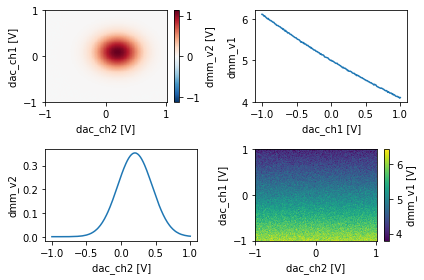

In [22]:
fig, ax = plt.subplots(2,2)
xaDataSet.dmm_v2.plot(ax=ax[0,0])
xaDataSet.dmm_v1.plot(ax=ax[1,1])
xaDataSet.dmm_v2.mean(dim='dac_ch1').plot(ax=ax[1,0])
xaDataSet.dmm_v1.mean(dim='dac_ch2').plot(ax=ax[0,1])
fig.tight_layout()

Above we demonstrated a few ways to index the data from a DataArray. For instance the DataArray can be directly plotted, the extracted mean or a specific row/column can also be plotted.